In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import itertools as it
from venn import venn
from upsetplot import plot as upsetplot
from matplotlib.lines import Line2D
from upsetplot import from_contents
import numpy as np
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Input data

In [6]:
networks={}
networks['HINT'] = nx.read_edgelist('2 - output/HINT.edgelist',delimiter='\t')
networks['IntAct'] = nx.read_edgelist('2 - output/IntAct.edgelist',delimiter='\t')
networks['Reactome'] = nx.read_edgelist('2 - output/Reactome.edgelist',delimiter='\t')
networks['STRING'] = nx.read_edgelist('2 - output/STRING.edgelist',delimiter='\t')

# Nodes Intersection

### Testing the library
Since the results show a HUGE difference between the PPINs, I double-check the results by hand and with a library.

In [4]:
## Testing the library
allNodes=[]
allNodes.extend(networks['HINT'].nodes)
allNodes.extend(networks['IntAct'].nodes)
uniqueNodes=set(allNodes)

nodesIntersection=0
nodesOnlyHINT=0
nodesOnlyIntAct=0
for node in uniqueNodes:
    if networks['IntAct'].has_node(node) and networks['HINT'].has_node(node):
        nodesIntersection+=1
    elif networks['IntAct'].has_node(node):
        nodesOnlyIntAct+=1
    else:
        nodesOnlyHINT+=1

print('% intersection',nodesIntersection/len(uniqueNodes))
print('% IntAct Only',nodesOnlyIntAct/len(uniqueNodes))
print('% HINT Only',nodesOnlyHINT/len(uniqueNodes))

% intersection 0.7118167938931298
% IntAct Only 0.09844274809160306
% HINT Only 0.18974045801526718


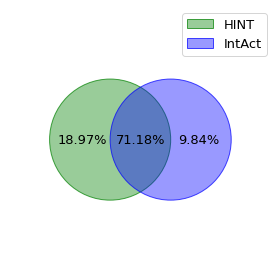

In [5]:
nodes={}
for name in ['HINT','IntAct']:
    nodes[name]=set(networks[name].nodes)
    
plt.figure(figsize=(4,8))
venn(nodes,fmt="{percentage:.2f}%",ax=plt.gca(),cmap=['green','blue'])
plt.tight_layout()
plt.show()

### Using in all networks

In [6]:
colors={
    'HINT':'#A2CD5A',
    'IntAct':'#00FFFF',
    'Reactome':'#FF8C00',
    'STRING':'#BF3EFF'
}

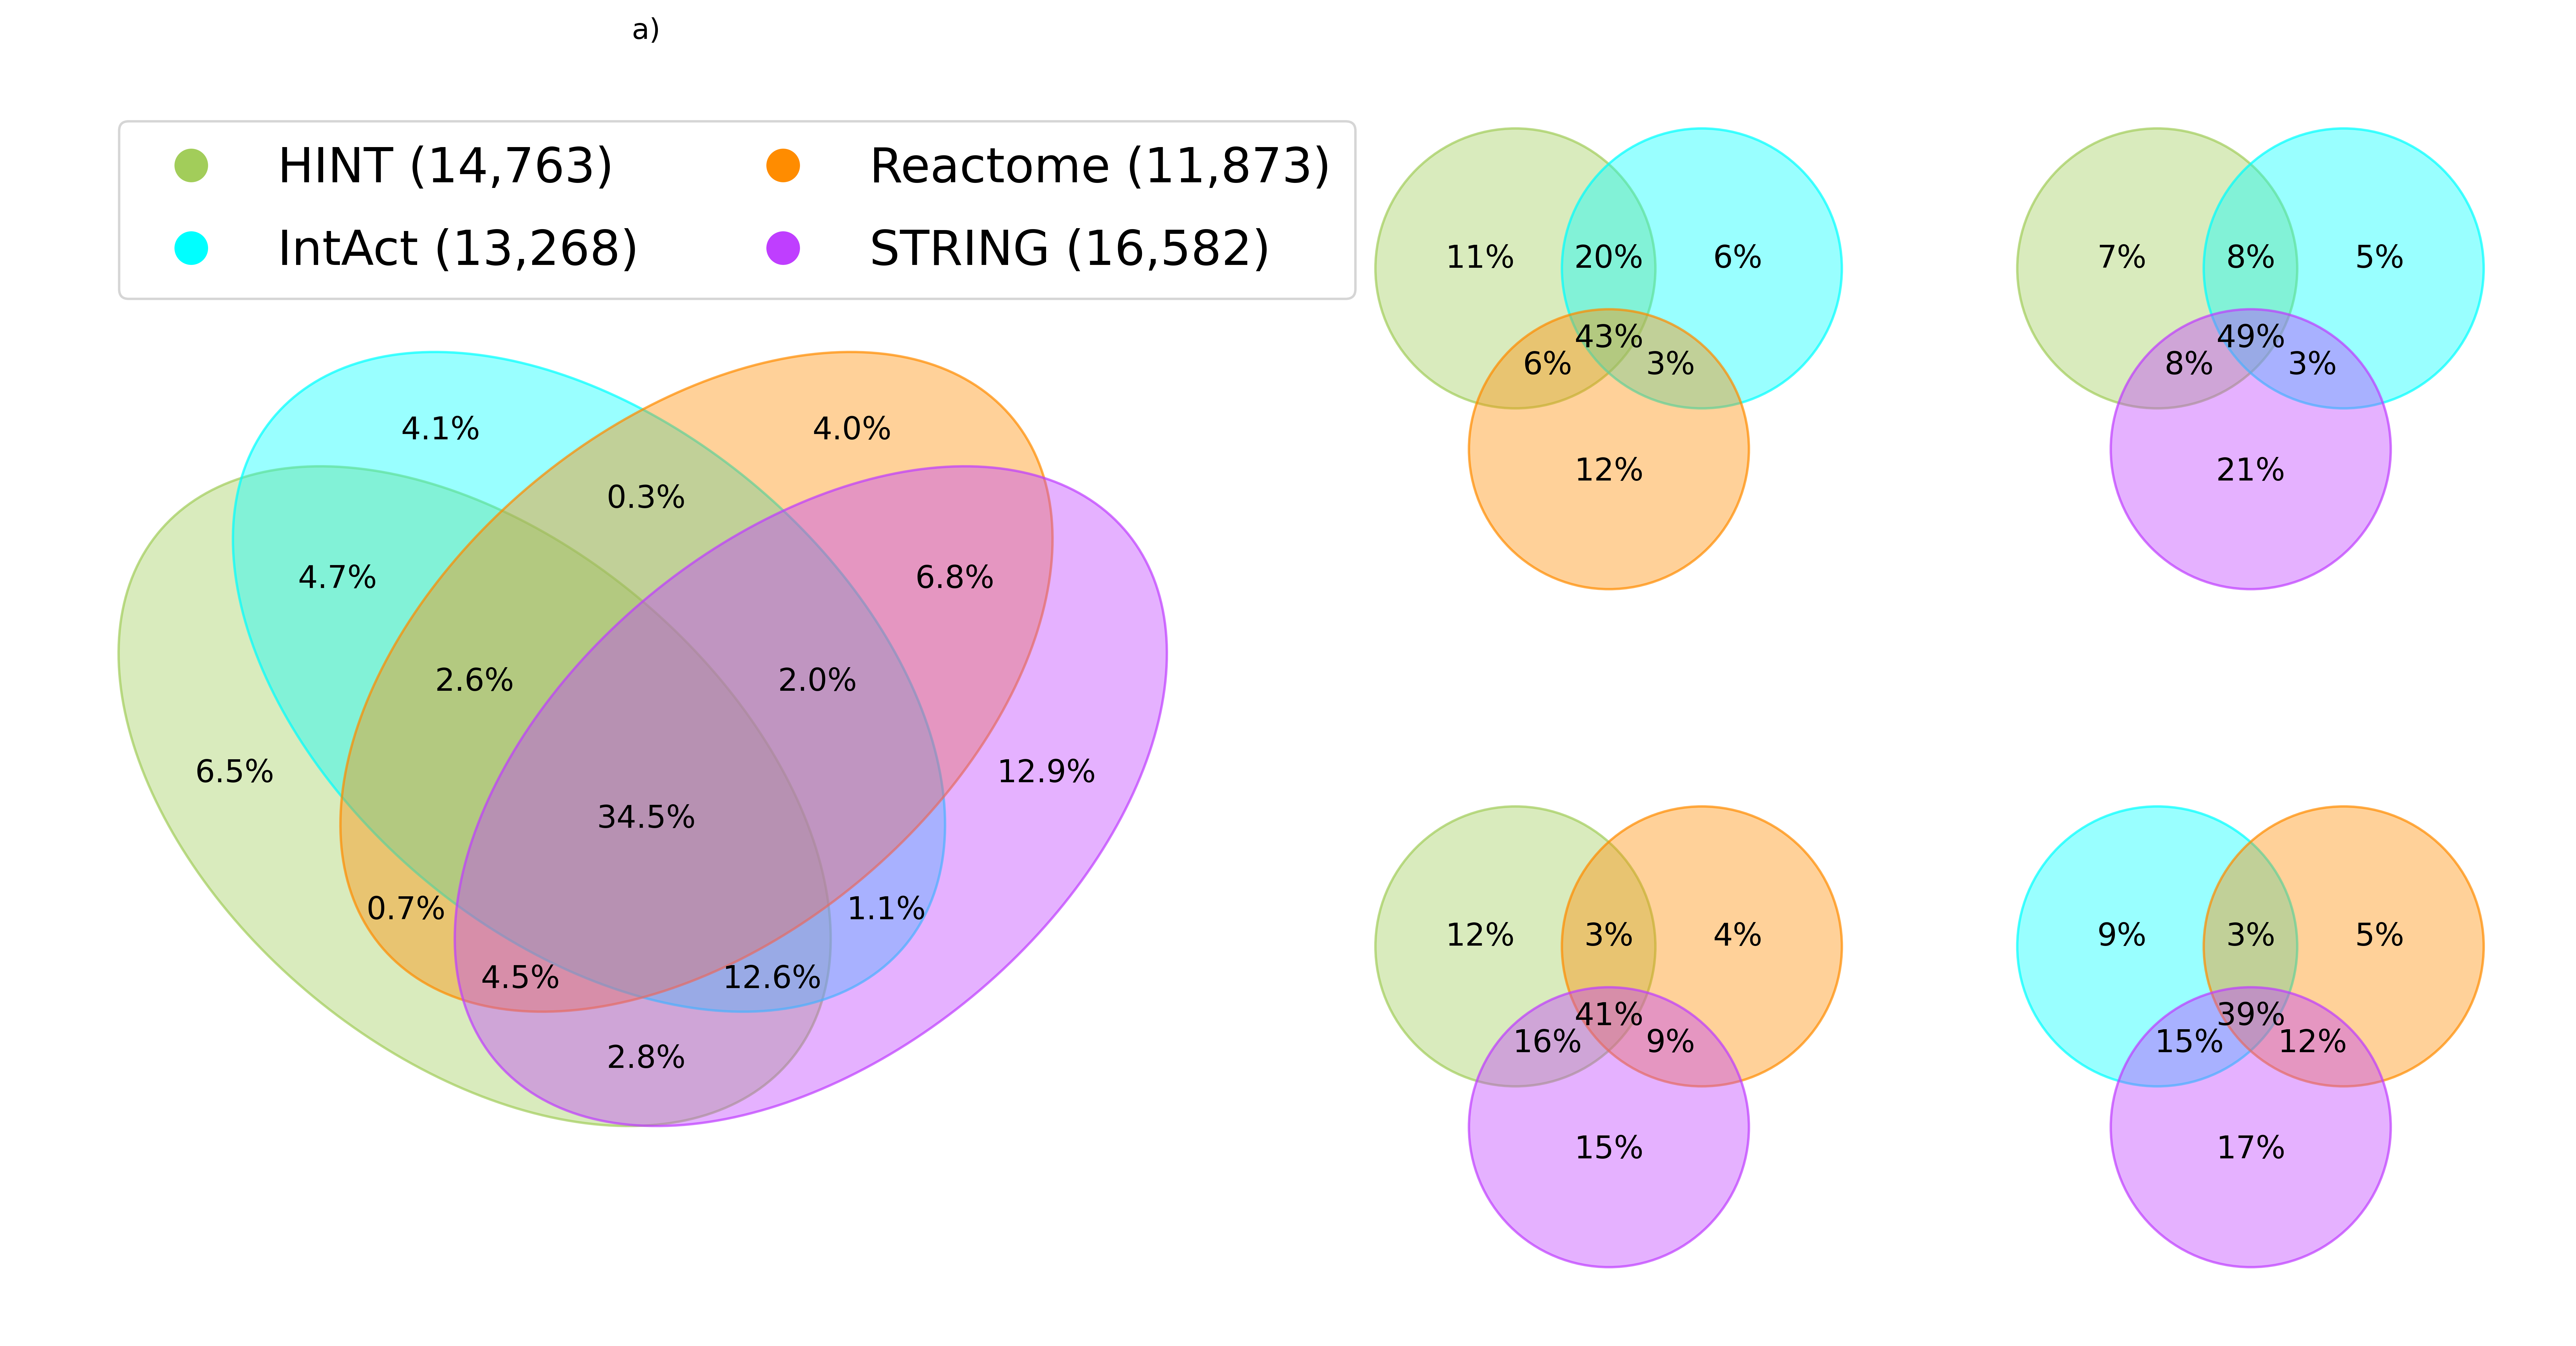

In [7]:
groups=list(it.combinations(sorted(networks.keys()),3))

plt.figure(figsize=(15,8),dpi=550)

axes=[
    plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2,rowspan=2),
    plt.subplot2grid(shape=(2, 4), loc=(0, 2)),
    plt.subplot2grid(shape=(2, 4), loc=(0, 3)),
    plt.subplot2grid(shape=(2, 4), loc=(1, 2)),
    plt.subplot2grid(shape=(2, 4), loc=(1, 3))
]

axes[0].set_title('a)')

#4 circles diagram
nodes={}
for name in networks:
    nodes[name]=set(networks[name].nodes)

venn(nodes,fmt="{percentage:.1f}%",ax=axes[0],cmap=list(colors.values()),legend_loc=None)
plt.tight_layout()
#3 circles diagram
for i,triple in enumerate(groups):
    nodes={}
    for name in triple:
        nodes[name]=set(networks[name].nodes)
    colorList=[color for netName,color in colors.items() if netName in triple]
    
    venn(nodes,fmt="{percentage:.0f}%",ax=axes[i+1],cmap=colorList,legend_loc=None)
    plt.tight_layout()

    
#Adding the legend
legend_elements=[]
for n in colors:
    color=colors[n]
    #add the number of nodes
    nameWithNodesCount=n+' ('+"{:,}".format(networks[n].number_of_nodes())+')'
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=nameWithNodesCount,markerfacecolor=color, markersize=15)
    )
plt.legend(
        handles=legend_elements, loc='upper left', bbox_to_anchor=(-3, 2), 
        ncol=int(len(legend_elements)/2),labelspacing=0.75,borderpad=0.5,fontsize="20"
      )
#plt.tight_layout()
# plt.savefig("2.2 - output/Nodes Intersection.png", format='png',facecolor='white')
# plt.savefig("2.2 - output/Nodes Intersection.pdf", format='pdf', dpi=1000,facecolor='white')
plt.show()

#### Number of unique nodes

In [8]:
allNodes=[]
for name in networks:
    allNodes.extend(list(networks[name].nodes))
print('All nodes sum:',len(allNodes))
uniqueNodes=set(allNodes)
print('All unique:',len(uniqueNodes))

All nodes sum: 56486
All unique: 21475


In [10]:
print('All unique:',len(uniqueNodes)*0.345)

All unique: 7408.874999999999


#### Pairwise 
The heatmap show how much (in %) the nodes of one network is inside another network

In [11]:
resume={}
for name1 in networks:
    resume[name1]={}
    for name2 in networks:
        if name1==name2:
            resume[name1][name2]=np.nan
        else:
            intersetionSize=len(set(networks[name1].nodes)&set(networks[name2].nodes))
            resume[name1][name2]=round(intersetionSize/networks[name1].number_of_nodes()*100,0)

In [12]:
pd.DataFrame(resume).T

HINT  IntAct  Reactome  STRING
HINT       NaN    79.0      61.0    79.0
IntAct    88.0     NaN      64.0    81.0
Reactome  76.0    71.0       NaN    86.0
STRING    70.0    65.0      62.0     NaN

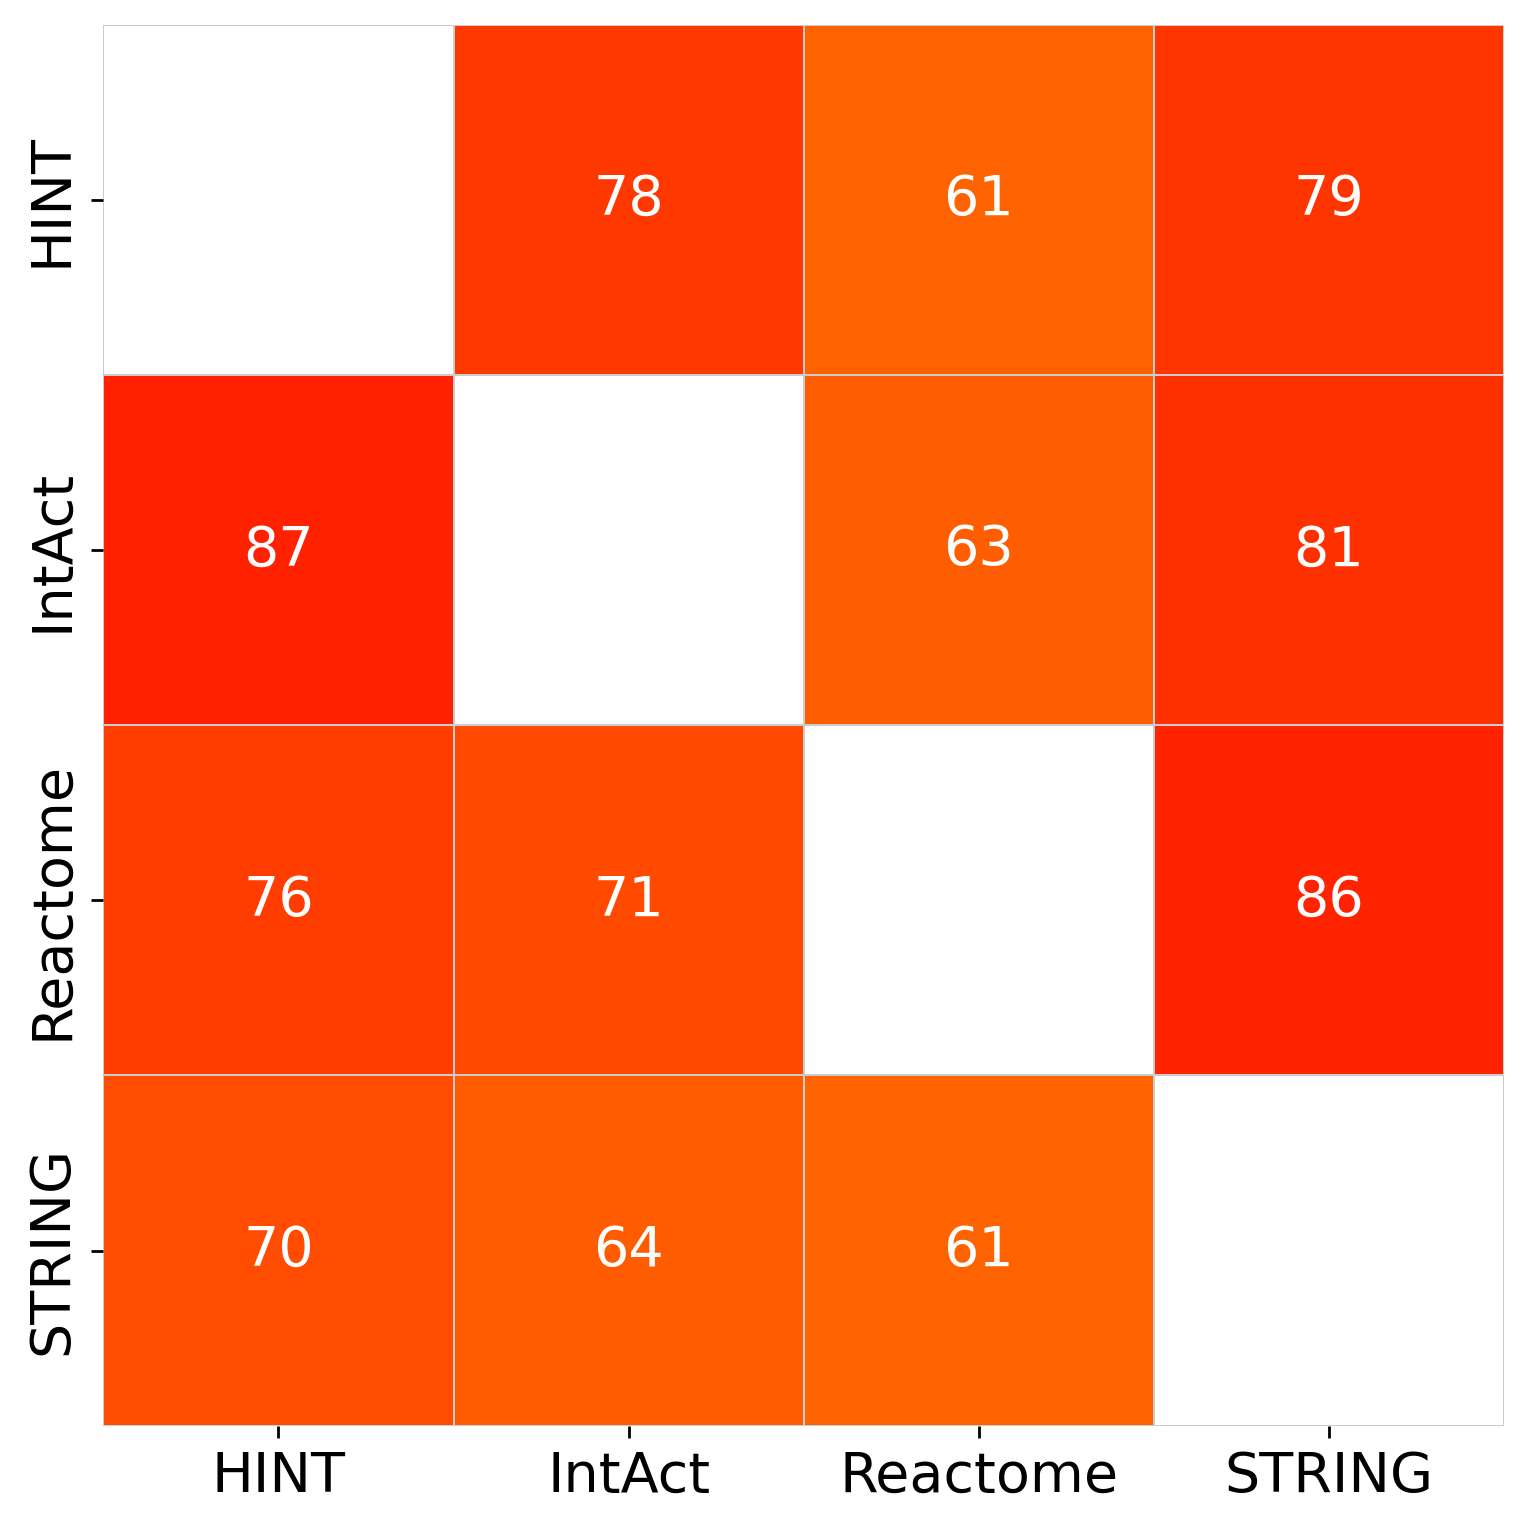

In [53]:
plt.figure(figsize=(6,6),dpi=250)
cmap = sns.color_palette("autumn_r", as_cmap=True)
sns.heatmap(pd.DataFrame(resume).T,annot=True, fmt=".0f", 
           linewidths=0.5, linecolor='#ccc',cmap=cmap, vmin=0, vmax=100, 
           cbar=False, square=True,annot_kws={"size": 16},)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
#plt.title(measure.upper(),y=0.97,fontsize=10)
plt.tight_layout(pad=0.3)
plt.savefig("2.2 - output/nodes pairwaise intersection.png", format='png', dpi=550,facecolor="white")
plt.show()

#### Edge Intersection
Since the edges are undirected, and networkX store then as a list of tuples, we need to make sure the set S1=[('A','B'),('B','C')] is igual to S2=[('B','A'),('C','A')].
In other words, the node order in the edge is not important.

In [20]:
allEdges=[]
allEdges.extend(networks['HINT'].edges)
allEdges.extend(networks['IntAct'].edges)

edgesIntersectionSet=set()
edgesIntersectionSetUnsorted=set()
for edge in allEdges:
    if networks['IntAct'].has_edge(*edge) and networks['HINT'].has_edge(*edge):
        edgesIntersectionSet.add(tuple(sorted(edge)))
        edgesIntersectionSetUnsorted.add(edge)

print('intersection',len(edgesIntersectionSet))
print('intersection unsorted',len(edgesIntersectionSetUnsorted))

intersection 70900
intersection unsorted 93020


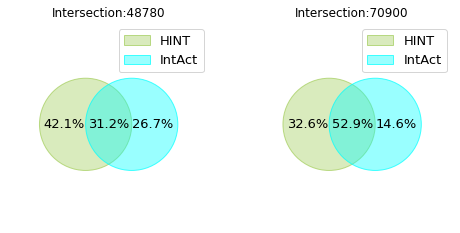

In [21]:
plt.figure(figsize=(8,8))

edges={}
for name in ['HINT','IntAct']:
    edges[name]=set(networks[name].edges)
plt.subplot(1,2,1)    
venn(edges,fmt="{percentage:.1f}%",cmap=list(colors.values()),ax=plt.gca())
plt.title('Intersection:'+str(len(edges['HINT']&edges['IntAct'])))


edges={}
for name in ['HINT','IntAct']:
    edges[name]=set([tuple(sorted(edge)) for edge in networks[name].edges])
plt.subplot(1,2,2)  
venn(edges,fmt="{percentage:.1f}%",cmap=list(colors.values()),ax=plt.gca())

plt.title('Intersection:'+str(len(edges['HINT']&edges['IntAct'])))
plt.show()

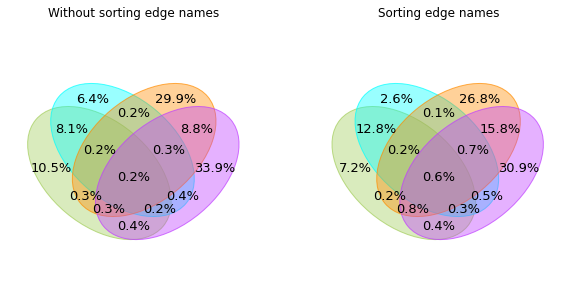

In [22]:
plt.figure(figsize=(10,10))

edges={}
for name in networks:
    edges[name]=set(networks[name].edges)
plt.subplot(1,2,1)  
venn(edges,fmt="{percentage:.1f}%",cmap=list(colors.values()),legend_loc=None,ax=plt.gca())
plt.title('Without sorting edge names')

edges={}
for name in networks:
    edges[name]=set([tuple(sorted(edge)) for edge in networks[name].edges])
plt.subplot(1,2,2) 
plt.title('Sorting edge names')
venn(edges,fmt="{percentage:.1f}%",cmap=list(colors.values()),legend_loc=None,ax=plt.gca())
plt.show()

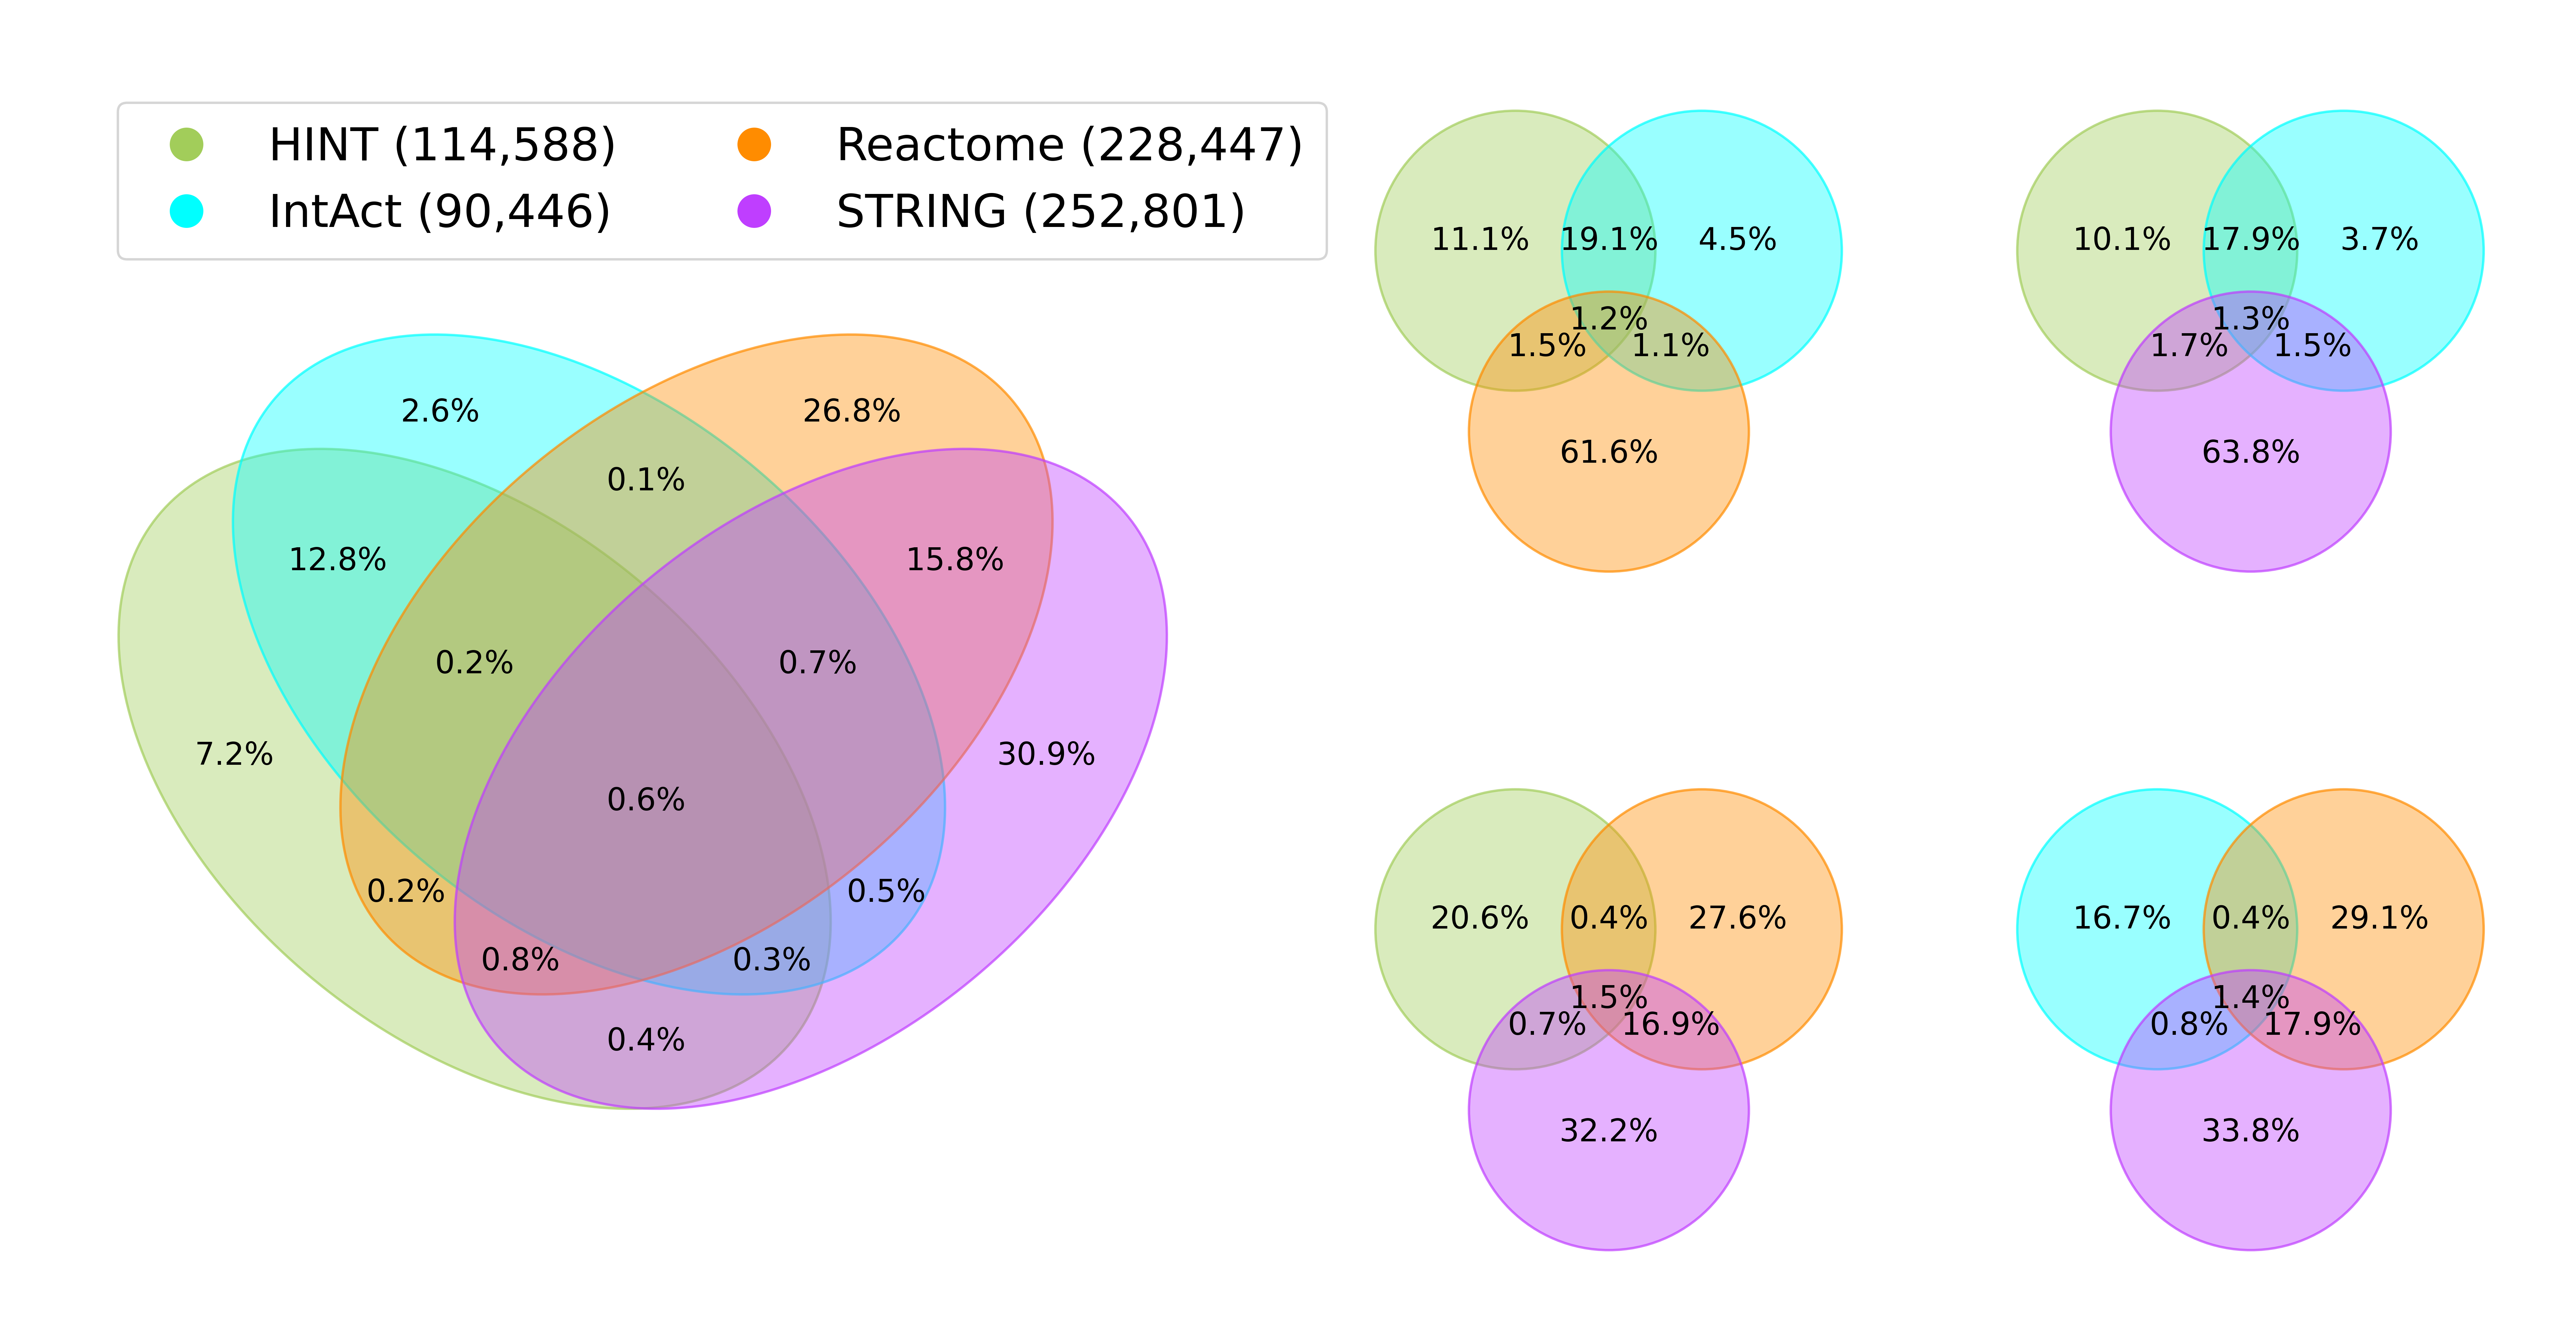

In [28]:
groups=list(it.combinations(sorted(networks.keys()),3))

plt.figure(figsize=(15,8),dpi=550)

axes=[
    plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2,rowspan=2),
    plt.subplot2grid(shape=(2, 4), loc=(0, 2)),
    plt.subplot2grid(shape=(2, 4), loc=(0, 3)),
    plt.subplot2grid(shape=(2, 4), loc=(1, 2)),
    plt.subplot2grid(shape=(2, 4), loc=(1, 3))
]

#4 circles diagram
edges={}
for name in networks:
    edges[name]=edges[name]=set([tuple(sorted(edge)) for edge in networks[name].edges])

venn(edges,fmt="{percentage:.1f}%",ax=axes[0],cmap=list(colors.values()),legend_loc=None)
plt.tight_layout()
#3 circles diagram
for i,triple in enumerate(groups):
    edges={}
    for name in triple:
        edges[name]=edges[name]=set([tuple(sorted(edge)) for edge in networks[name].edges])
    colorList=[color for netName,color in colors.items() if netName in triple]
    
    venn(edges,fmt="{percentage:.1f}%",ax=axes[i+1],cmap=colorList,legend_loc=None)
    plt.tight_layout()

    
#Adding the legend
legend_elements=[]
for n in colors:
    color=colors[n]
    #add the number of edges
    nameWithedgesCount=n+' ('+"{:,}".format(networks[n].number_of_edges())+')'
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=nameWithedgesCount,markerfacecolor=color, markersize=15)
    )
plt.legend(
        handles=legend_elements, loc='upper left', bbox_to_anchor=(-3, 2), 
        ncol=int(len(legend_elements)/2),labelspacing=0.5,borderpad=0.5,fontsize="19"
      )
plt.savefig("2.2 - output/Edges Intersection.png", format='png',facecolor='white')
plt.savefig("2.2 - output/Edges Intersection.pdf", format='pdf', dpi=1000,facecolor='white')
plt.show()

In [24]:
resume={}
for name1 in networks:
    resume[name1]={}
    for name2 in networks:
        if name1==name2:
            resume[name1][name2]=np.nan
        else:
            intersetionSize=len(
                set([tuple(sorted(edge)) for edge in networks[name1].edges])&
                set([tuple(sorted(edge)) for edge in networks[name2].edges])
            )
            resume[name1][name2]=round(intersetionSize/networks[name1].number_of_edges()*100)
pd.DataFrame(resume).T    

HINT  IntAct  Reactome  STRING
HINT       NaN    62.0       8.0    10.0
IntAct    78.0     NaN       9.0    12.0
Reactome   4.0     4.0       NaN    40.0
STRING     4.0     4.0      36.0     NaN

In [4]:
(4+4+36)/3

14.666666666666666

## Since the results showed 'extreme' values, I will do the same analysis changing the algorithm.

In [42]:
resume={}
for name1 in networks:
    resume[name1]={}
    for name2 in networks:
        intersectionCount=0
        for edge in networks[name1].edges():
            if networks[name2].has_edge(*edge):
                intersectionCount+=1
        resume[name1][name2]=intersectionCount/networks[name1].number_of_edges()*100

In [43]:
pd.DataFrame(resume).T

HINT      IntAct    Reactome      STRING
HINT      100.000000   61.873844    8.207666    9.557720
IntAct     78.389315  100.000000    9.145789   11.573757
Reactome    4.116929    3.620971  100.000000   39.543527
STRING      4.332261    4.140806   35.734036  100.000000

In [27]:
print('a wrong intersection, where (a,b) != (b,a)')
intersectionCount=0
l1=list(networks['HINT'].edges())
l2=list(networks['IntAct'].edges())
for edge in l1:
    if edge in l2:
        intersectionCount+=1
print(intersectionCount)
intersectionCount/networks['HINT'].number_of_edges()*100

a wrong intersection, where (a,b) != (b,a)
48780


42.56990260760289

In [28]:
print('a right intersection, where (a,b) == (b,a)')
intersectionCount=0
l1=list(networks['HINT'].edges())
l2=list(networks['IntAct'].edges())
l1 = [sorted(x) for x in l1]
l2 = [sorted(x) for x in l2]
for edge in l1:
    if edge in l2:
        intersectionCount+=1
print(intersectionCount)
intersectionCount/networks['HINT'].number_of_edges()*100

a right intersection, where (a,b) == (b,a)
70900


61.87384368345725

In [29]:
print('a right intersection, where (a,b) == (b,a)')
print('changing the algorithm to use Set')
l1=list(networks['HINT'].edges())
l2=list(networks['IntAct'].edges())
l1 = [tuple(sorted(x)) for x in l1]
l2 = [tuple(sorted(x)) for x in l2]
len(set(l1).intersection(set(l2)))/networks['HINT'].number_of_edges()*100

a right intersection, where (a,b) == (b,a)
changing the algorithm to use Set


61.87384368345725

In [11]:
print('Replicating the values from the edge intersection image')

l1=list(networks['HINT'].edges())
l2=list(networks['IntAct'].edges())
l3=list(networks['Reactome'].edges())
l4=list(networks['STRING'].edges())

s1 = set([tuple(sorted(x)) for x in l1])
s2 = set([tuple(sorted(x)) for x in l2])
s3 = set([tuple(sorted(x)) for x in l3])
s4 = set([tuple(sorted(x)) for x in l4])

U=s1.union(s2)
U=U.union(s3)
U=U.union(s4)

print('intersection among all networks',(len(s1&s2&s3&s4)/len(U))*100)
U=s1.union(s2)
U=U.union(s3)
print('intersection among HINT, IntAct and Reactome',(len(s1&s2&s3)/len(U))*100)

Replicating the values from the edge intersection image
intersection among all networks 0.623720769268799
intersection among HINT, IntAct and Reactome 1.2390079918449393


In [12]:
print('Replicating the values from the edge intersection image WITHOUT SORTING EDGES (A,B) != (B,A), WHICH IS WRONG.')

l1=list(networks['HINT'].edges())
l2=list(networks['IntAct'].edges())
l3=list(networks['Reactome'].edges())
l4=list(networks['STRING'].edges())

s1 = set([tuple(x) for x in l1])
s2 = set([tuple(x) for x in l2])
s3 = set([tuple(x) for x in l3])
s4 = set([tuple(x) for x in l4])

U=s1.union(s2)
U=U.union(s3)
U=U.union(s4)

print('intersection among all networks',(len(s1&s2&s3&s4)/len(U))*100)
U=s1.union(s2)
U=U.union(s3)
print('intersection among HINT, IntAct and Reactome',(len(s1&s2&s3)/len(U))*100)

Replicating the values from the edge intersection image WITHOUT SORTING EDGES (A,B) != (B,A), WHICH IS WRONG.
intersection among all networks 0.16206600762167256
intersection among HINT, IntAct and Reactome 0.49916141944709497


# UpSetPlot

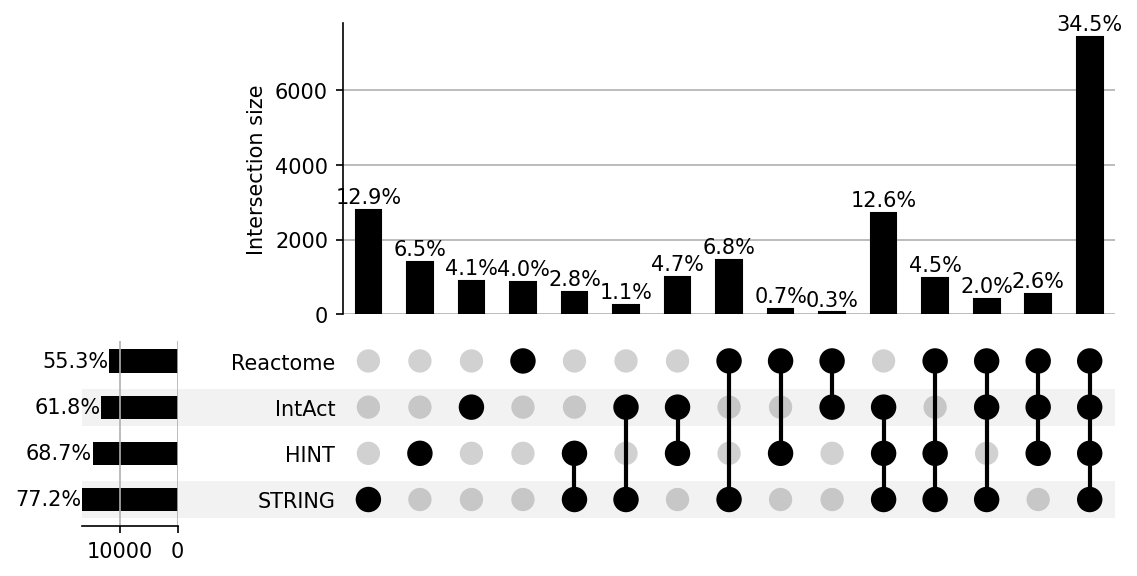

In [21]:
nodes={}
for name in networks:
    nodes[name]=set(networks[name].nodes)
    
nodesIntersection = from_contents(nodes)

plt.figure(dpi=150)
upsetplot(nodesIntersection,show_percentages=True,orientation='horizontal',fig=plt.gcf())
plt.show()

## Edges Between Cancer Genes

In [80]:
groups=list(it.combinations(['TP53','KRAS','PIKCA','BRAF','KMT2D','APC','ARID1A','WNT'],2))
groups=list(it.combinations(['TP53','KRAS','PIK3CA','BRAF','TTN'],2))
groups=sorted(list(it.combinations(['TP53','TNF','EGFR','VEGFA','APOE','IL6','TGFBI','ESR1','AKT1'],2)))

resume={}
for edge in groups:
    resume[edge[0]+'-'+edge[1]]={}
    for name in networks:
        resume[edge[0]+'-'+edge[1]][name]=1 if networks[name].has_edge(*edge) else ''
        print(nx.has_path(networks[name],*edge))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [81]:
pd.DataFrame(resume).T

HINT IntAct Reactome STRING
APOE-AKT1                              
APOE-ESR1                      1       
APOE-IL6                              1
APOE-TGFBI                             
EGFR-AKT1      1      1        1      1
EGFR-APOE                              
EGFR-ESR1             1        1      1
EGFR-IL6                       1      1
EGFR-TGFBI                             
EGFR-VEGFA                     1      1
ESR1-AKT1                      1      1
IL6-AKT1                              1
IL6-ESR1                               
IL6-TGFBI                              
TGFBI-AKT1                             
TGFBI-ESR1                             
TNF-AKT1                              1
TNF-APOE                              1
TNF-EGFR                              1
TNF-ESR1                               
TNF-IL6                               1
TNF-TGFBI                              
TNF-VEGFA                             1
TP53-AKT1      1               1      1
TP53-APOE                              
TP53-EGFR                      1      1
TP53-ESR1                             1
TP53-IL6                              1
TP53-TGFBI                             
TP53-TNF                              1
TP53-VEGFA                     1      1
VEGFA-AKT1                     1      1
VEGFA-APOE                             
VEGFA-ESR1                             
VEGFA-IL6                             1
VEGFA-TGFBI

In [77]:
groups=sorted(list(it.combinations(['TP53','TNF','EGFR','VEGFA','APOE','IL6','TGFBI','ESR1','AKT1'],2)))

resume={}
for edge in groups:
    resume[edge[0]+'-'+edge[1]]={}
    for name in networks:
        resume[edge[0]+'-'+edge[1]][name]=1 if networks[name].has_edge(*edge) else ''
        print(nx.has_path(networks[name],*edge))

114588